In [5]:
import sys
from pathlib import Path

project_root = Path("..").resolve()

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("Project root added to sys.path:", project_root)


Project root added to sys.path: /Users/tharungopinath/Desktop/Q-A Agentic AI


In [6]:
from dotenv import load_dotenv
import os
load_dotenv()
print("GROQ_API_KEY loaded:", bool(os.getenv("GROQ_API_KEY")))


GROQ_API_KEY loaded: True


In [12]:

proj_root = Path.cwd().resolve()
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

from graph import build_agent_graph
from agents.memory import Memory

g = build_agent_graph()
mem = Memory(maxlen=6)
print("AgentGraph and Memory created")

AgentGraph and Memory created


In [13]:

q = "What is Python?"
mem.append("user", q)
res = g.route_query(q, mem)
print("Response:", res)
mem.append("assistant", res['answer'])
print("Memory now:", mem.to_list())

Response: {'answer': '(tool) Python is a high-level, interpreted programming language known for readability.', 'source': 'tool', 'metadata': {'tool_match': True}}
Memory now: [{'role': 'user', 'text': 'What is Python?'}, {'role': 'assistant', 'text': '(tool) Python is a high-level, interpreted programming language known for readability.'}]


In [14]:
q2 = "Tell me a short joke."
mem.append("user", q2)
res2 = g.route_query(q2, mem)
print("Response:", res2)
mem.append("assistant", res2['answer'])
print("Memory now:", mem.to_list())

Response: {'answer': "Why couldn't the bicycle stand up by itself? Because it was two-tired.", 'source': 'llm', 'metadata': {'tool_match': False}}
Memory now: [{'role': 'user', 'text': 'What is Python?'}, {'role': 'assistant', 'text': '(tool) Python is a high-level, interpreted programming language known for readability.'}, {'role': 'user', 'text': 'Tell me a short joke.'}, {'role': 'assistant', 'text': "Why couldn't the bicycle stand up by itself? Because it was two-tired."}]


In [10]:
mem.clear()
print("Cleared. Memory:", mem.to_list())

Cleared. Memory: []


In [15]:
from agents.fact_detection import is_factual, small_search_tool
from agents.interface import answer_question
from typing import Dict, Any

def chatbot_node(state: Dict[str, Any]) -> Dict[str, Any]:
    raw = state.get("messages", "")

    if isinstance(raw, list):
        query = raw[-1] if raw else ""
        if not isinstance(query, str):
            query = str(query)
    else:
        query = str(raw)

    try:
        if is_factual(query):
            tool_ans = small_search_tool(query)
            if tool_ans:
                return {"messages": f"(tool) {tool_ans}"}
    except Exception:
        pass  

    try:
        reply = answer_question(query, memory=[])
        reply_text = reply if isinstance(reply, str) else str(reply)
    except Exception as e:
        reply_text = f"LLM error: {e}"

    return {"messages": reply_text}


In [16]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

In [17]:
class State(TypedDict):
    messages: list

In [18]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

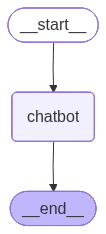

In [19]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))